# **Image Transformations**

In [ ]:
import numpy as np
from skimage import io
import cv2
import matplotlib.pyplot as plt

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
image = io.imread(url, as_gray=True)

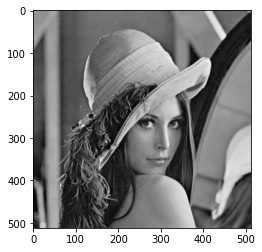

In [ ]:
plt.imshow(image, cmap = plt.get_cmap(name = 'gray'))

In [ ]:
class GeometricTransform(object):
    """
    Base class for image geometric transformations.
    """
    def __call__(self, coords):
        """
        Apply geometric transformation.
        """
        raise NotImplementedError()


    def _get_new_bounds(self, shape, matrix):
        """
        Calculate the boundaries of the new image.
        Parameters
        ----------
        shape: tuple
            Shape of original image in (H, W)
            matrix: A 2*3 transformation matrix
        Returns
        ------- 
        h_min, h_max, w_min, w_max: tuple
            New image boundaries.
        """
        points = [[0, 0], [shape[1], 0], 
                  [0, shape[0]], [shape[1], shape[0]]]
        new_points = np.array([self._transform_point((pt[0], pt[1]), matrix) for pt in points])

        h_min = np.min(new_points[:, 0])
        h_max = np.max(new_points[:, 0])

        w_min = np.min(new_points[:, 1])
        w_max = np.max(new_points[:, 1])
        return h_min, h_max, w_min, w_max


    def _transform_point(self, point, matrix):
        """
        Transform a point from given transformation matrix.
        Parameters
        ----------
        point: tuple
            (H, W) co-ordinate of point to rotate
        matrix: ndarray
            A 2*3 transformation matrix
        Returns
        ------- 
        new_point: array 
            (H, W) co-ordinates of new point.
        """
        H, W = point
        a, b, c, d, e, f = matrix
        x, y = a * H + b * W + c, d * H + e * W + f
        return [int(x), int(y)]


    def _check_bounds(self, point, shape):
        """
        Checks if a point is in bounds of a shape.
        Parameters
        ----------
        point: tuple
            (H co-ordinate , W, co-ordinate)
        shape: tuple
            (Height, Width)
        Returns
        ------- 
        boolean:
            If a point is within the boundaries 
            of the given image, it is False if it is not True.
        """
        if (point[1] <= 0) or (point[1] >= shape[1]):
            return True
        elif (point[0] <= 0) or (point[0] >= shape[0]):
            return True
        else:
            return False


    def translate(self, coords):
        """
        Apply inverse transformation.
        Parameters
        ----------
        coords : (N, 2) array
            Destination coordinates.
        Returns
        -------
        coords : (N, 2) array
            Source coordinates.
        """
        raise NotImplementedError()


    def rotate(self, image, angle):
        """
        Rotates a given image.
        Parameters
        ----------
        image : (H, W) array
            A grayscale source image in (H, W) format.
        angle : int
            Angle of rotation in degrees.
        Returns
        -------
        rotated_image : (H, W) array
            Rotated image.
        """
        raise NotImplementedError()

In [ ]:
class Rotation(GeometricTransform):
    """
    Each pixel has a coordinate pair (x,y) describing its position 
    on two orthogonal axes from defined origin O. 
    It is around this origin to rotate given image. 
    This class inherited from GeometricTransform class.
    """
    def __call__(self, image, angle):
        return self.rotate(image, angle)


    def _get_rotation_matrix(self, shape, angle, adjust_boundaries=True):
        """
        Calculates the 2D rotation matrix from 
        given angle and image shape.
        Parameters
        ----------
        shape: tuple
            (Height, Width) 
        angle: int
            Angle of rotation in degrees
        Returns
        ------- 
        rotation_matrix: ndarray
            The 2D rotation matrix.
        """
        angle = np.deg2rad(angle)

        H, W = shape
        cy, cx = H / 2, W / 2

        a = np.math.cos(angle)
        b = np.math.sin(angle)
        xc1 = -cx
        xc2 = cx
        yc1 = -cy
        yc2 = cy

        rotation_matrix = [
            a, -b, 
            xc1 * a - yc1 * b + xc2, 
            b, a, 
            xc1 * b + yc1 * a + yc2
        ]

        if adjust_boundaries:
            x_min, x_max, y_min, y_max = self._get_new_bounds((H, W), rotation_matrix)
            new_img = np.zeros((y_max - y_min, x_max - x_min))

            new_cy, new_cx = new_img.shape[0] / 2, new_img.shape[1] / 2

            y_shift = cy - new_cy
            x_shift = cx - new_cx

            rotation_matrix[2] -= x_shift # tx
            rotation_matrix[5] -= y_shift # ty
        return rotation_matrix


    def rotate(self, image, angle):
        """
        Rotates a given image.
        Parameters
        ----------
        image : (H, W) array
            A grayscale source image in (H, W) format.
        angle : int
            Angle of rotation in degrees.
        Returns
        -------
        new_image : (H, W) array
            Rotated image.
        """
        H, W = image.shape
        rotation_matrix = self._get_rotation_matrix((H, W), angle)
        h_min, h_max, w_min, w_max = self._get_new_bounds((H, W), rotation_matrix)
        new_image = np.zeros((h_max, w_max))
        for i in range(H):
            for j in range(W):
                new_point = self._transform_point((j, i), rotation_matrix)
                if self._check_bounds((new_point[1], new_point[0]), new_image.shape):
                    continue
                else:
                    new_image[new_point[1]][new_point[0]] = image[i][j]
        return new_image

In [ ]:
class Translation(GeometricTransform):
    """
    A translation moves an object to a different position 
    on the image. You can translate a point in 2D by adding 
    translation coordinate (tx, ty) to the original coordinate X,Y 
    to get the new coordinate X′,Y′. This class inherited from
    GeometricTransform class.
    """
    def __call__(self, image, coords):
        return self.translate(image, coords)
    

    def _get_translation_matrix(self, coords):
        """
        Calculates the 2D translation matrix from 
        given coordinates.
        Parameters
        ----------
        coords : tuple
            (x, y) Coordinates to shift.
        Returns
        ------- 
        translation_matrix: ndarray
            The 2D translation matrix.
        """
        translation_matrix = [1, 0, coords[0], 0, 1, coords[1]] 
        return translation_matrix


    def translate(self, image, coords):
        """
        Translate a given image.
        Parameters
        ----------
        image : (H, W) array
            A grayscale source image in (H, W) format.
        coords : tuple
            (x, y) Coordinates to shift.
        Returns
        -------
        new_image : (H, W) array
            Translated image.
        """
        H, W = image.shape
        translation_matrix = self._get_translation_matrix(coords)
        h_min, h_max, w_min, w_max = self._get_new_bounds((H, W), translation_matrix)
        new_image = np.zeros((H, W))
        for i in range(H):
            for j in range(W):
                new_point = self._transform_point((j, i), translation_matrix)
                if self._check_bounds((new_point[1], new_point[0]), new_image.shape):
                    continue
                else:
                    new_image[new_point[1]][new_point[0]] = image[i][j]
        return new_image

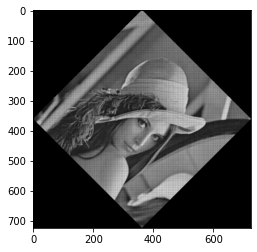

In [ ]:
rotate = Rotation()
# for anti-aliasing
smoothed_image = cv2.GaussianBlur(image, (3, 3), cv2.BORDER_DEFAULT)
rotated_image = rotate(smoothed_image, 45)
plt.imshow(rotated_image, cmap = plt.get_cmap(name = 'gray'))

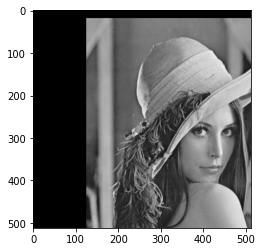

In [ ]:
translate = Translation()
points = (125, 19)
translated_image = translate(image, points)
plt.imshow(translated_image, cmap = plt.get_cmap(name = 'gray'))

# **References**

*  [Translation](https://www.gatevidyalay.com/2d-transformation-in-computer-graphics-translation-examples/#:~:text=2D%20Translation%20is%20a%20process,another%20in%20a%202D%20plane.&text=Tx%20defines%20the%20distance,coordinate%20has%20to%20be%20moved.)

*  [Rotation](https://www.gatevidyalay.com/2d-rotation-in-computer-graphics-definition-examples/)

*  [Geometric Transformation](https://towardsdatascience.com/image-geometric-transformation-in-numpy-and-opencv-936f5cd1d315#:~:text=Geometric%20transformation%20is%20an%20essential,image%20to%20another%20image%20plane.)

*  [Affine Transform Formulas](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.AffineTransform)

*  [Rotation 2D](https://datagenetics.com/blog/august32013/index.html)